In [1]:
import json
import os
import math
import librosa

DATASET_PATH = "C:/Users/HASSAN/Downloads/archive/Data/genres_original"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T


                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: genres_original\blues
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:1
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:2
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:3
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:4
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:5
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:6
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:7
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:8
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:9
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00000.wav, segment:10
C:/Users/HASSAN/Downloads/archive/Data/genres_original\blues\blues.00001.wav, segmen

In [7]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 11, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 6, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 62, 4, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 31, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 1, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 15, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1829 - loss: 2.7036 - val_accuracy: 0.3531 - val_loss: 1.8483
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3368 - loss: 1.9663 - val_accuracy: 0.4219 - val_loss: 1.5879
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4150 - loss: 1.7113 - val_accuracy: 0.4573 - val_loss: 1.4597
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4609 - loss: 1.5418 - val_accuracy: 0.5147 - val_loss: 1.3562
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4885 - loss: 1.4565 - val_accuracy: 0.5200 - val_loss: 1.2906
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5066 - loss: 1.4067 - val_accuracy: 0.5514 - val_loss: 1.2495
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5375 - loss: 1.3199 - val_accuracy: 0.5661 - val_loss: 1.1979
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5381 - loss: 1.2899 - val_acc

KeyboardInterrupt: 

In [8]:

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates RNN-LSTM model

    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

C:\Users\HASSAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 130, 64)             │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,802 (225.79 KB)

 Trainable params: 57,802 (225.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.1699 - loss: 2.2531 - val_accuracy: 0.3298 - val_loss: 2.0417
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3218 - loss: 1.9901 - val_accuracy: 0.3792 - val_loss: 1.8011
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.3695 - loss: 1.7855 - val_accuracy: 0.4252 - val_loss: 1.6593
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.4255 - loss: 1.6581 - val_accuracy: 0.4499 - val_loss: 1.5708
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.4460 - loss: 1.5742 - val_accuracy: 0.4746 - val_loss: 1.4994
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.4724 - loss: 1.5070 - val_accuracy: 0.4927 - val_loss: 1.4528
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.4332 - loss: 1.5808 - val_accuracy: 0.4766 - val_loss: 1.4517
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5030 - loss: 1.4291 

KeyboardInterrupt: 

In [3]:
import os
import pandas as pd
import librosa
from tqdm import tqdm

METADATA_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/filtered_tracks_metadata.csv'
DATASET_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large'
MIN_SAMPLES = 22050 * 30  # Minimum required samples, e.g., 30 seconds at 22050 Hz

def downsample_tracks(metadata_path, downsample_ratios):
    """
    Downsamples tracks for each genre according to specified ratios in metadata only.

    Parameters:
        metadata_path (str): Path to the custom metadata CSV file.
        downsample_ratios (dict): Dictionary with genres as keys and downsampling factors (0-1) as values.

    Returns:
        DataFrame: Downsampled DataFrame of tracks.
    """
    # Load the metadata file
    tracks = pd.read_csv(metadata_path, index_col=0)

    # Initialize an empty list to store downsampled DataFrames
    downsampled_dfs = []

    # Loop through each genre and apply downsampling
    for genre, ratio in downsample_ratios.items():
        genre_tracks = tracks[tracks['primary_genre'] == genre]

        # Downsample if ratio < 1, otherwise keep all tracks
        if ratio < 1:
            num_samples = int(len(genre_tracks) * ratio)
            genre_tracks_downsampled = genre_tracks.sample(num_samples, random_state=42)
            print(f"Downsampled {genre} from {len(genre_tracks)} to {len(genre_tracks_downsampled)} tracks")
        else:
            genre_tracks_downsampled = genre_tracks
            print(f"Kept all tracks for {genre} (total: {len(genre_tracks)})")

        downsampled_dfs.append(genre_tracks_downsampled)

    # Combine all downsampled DataFrames
    downsampled_tracks = pd.concat(downsampled_dfs)

    # Display the final count of tracks per genre
    print("\nNumber of tracks per genre after downsampling:")
    print(downsampled_tracks['primary_genre'].value_counts())

    return downsampled_tracks

# Define downsampling ratios for each genre
# downsample_ratios = {
#     'Electronic': 0.078,
#     'Avant-Garde': 0.175,
#     'Experimental': 0.2,
#     'Rock': 0.225,
#     'Pop': 0.26,
#     'Folk': 0.35,
#     'Hip-Hop': 0.37,
#     'Punk': 0.42,
#     'Noise': 0.44,
#     'Lo-Fi': 0.55,
#     'Experimental Pop': 0.55,
#     'Ambient Electronic': 0.74,
#     'Jazz': 0.86,
#     'Classical': 0.90,
#     'International': 0.95,
#     'Blues': 1.0,  # Keep all for Blues
# }
downsample_ratios = {
'Experimental'           :0.013883,
'Avant-Garde'            :0.034118,
'Rock'                   :0.044863,
'Folk'                   :0.045935,
'Hip-Hop'                :0.049383,
'Blues'                   :0.151057,
'Singer-Songwriter'       :0.152905,
'Classical'               :0.177620,
'Techno'                  :0.178571,
'Jazz'                    :0.195695,
'Reggae - Dub'            :0.336700,
'Country'                 :0.341297,
'Metal'                   :0.350877,
'Old-Time / Historic'     :0.534759,
'New Wave'                :0.568182,
'Novelty'                  :1,
}




# Perform downsampling
downsampled_tracks = downsample_tracks(METADATA_PATH, downsample_ratios)

# Optional: Save the downsampled data to a new CSV
downsampled_tracks.to_csv('downsampled_tracks_metadata.csv')





Downsampled Experimental from 7203 to 99 tracks
Downsampled Avant-Garde from 2931 to 99 tracks
Downsampled Rock from 2229 to 99 tracks
Downsampled Folk from 2177 to 100 tracks
Downsampled Hip-Hop from 2025 to 100 tracks
Downsampled Blues from 662 to 99 tracks
Downsampled Singer-Songwriter from 654 to 99 tracks
Downsampled Classical from 563 to 100 tracks
Downsampled Techno from 560 to 99 tracks
Downsampled Jazz from 511 to 100 tracks
Downsampled Reggae - Dub from 297 to 99 tracks
Downsampled Country from 293 to 100 tracks
Downsampled Metal from 285 to 99 tracks
Downsampled Old-Time / Historic from 187 to 99 tracks
Downsampled New Wave from 176 to 100 tracks
Kept all tracks for Novelty (total: 87)

Number of tracks per genre after downsampling:
primary_genre
Folk                   100
Hip-Hop                100
Classical              100
Jazz                   100
Country                100
New Wave               100
Experimental            99
Avant-Garde             99
Rock            

In [1]:
import pandas as pd
import os
import librosa
from tqdm import tqdm

# Paths and settings
METADATA_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_metadata/fma_metadata/custom_tracks_metadata.csv'
DATASET_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large'
MIN_SAMPLES = 12000 * 30  # Set the minimum sample threshold (e.g., 30 seconds at 22050 Hz)

def filter_short_tracks(metadata_path, dataset_path, min_samples):
    """
    Filters out tracks with a sample count less than the specified threshold.

    Parameters:
        metadata_path (str): Path to the metadata CSV file.
        dataset_path (str): Path to the directory with audio files.
        min_samples (int): Minimum number of samples required for a track to be included.

    Returns:
        DataFrame: Filtered DataFrame of tracks.
    """
    # Load metadata
    tracks = pd.read_csv(metadata_path, index_col=0)

    # List to store valid track IDs
    valid_tracks = []

    # Progress bar for filtering
    print("Filtering tracks by minimum sample requirement...")
    for track_id in tqdm(tracks.index, desc="Checking track length"):
        folder = f"{int(track_id):03d}"[:3]  # Folder based on track_id
        file_path = os.path.join(dataset_path, folder, f"{track_id}.mp3")

        if os.path.isfile(file_path):
            try:
                # Load audio file and check length
                signal, _ = librosa.load(file_path, sr=None)
                if len(signal) >= min_samples:
                    valid_tracks.append(track_id)  # Track meets minimum sample requirement
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    # Filter metadata to include only valid tracks
    filtered_tracks = tracks.loc[valid_tracks]

    # Display the final count of tracks per genre
    print("\nNumber of tracks per genre after filtering:")
    print(filtered_tracks['primary_genre'].value_counts())

    return filtered_tracks

# Apply filtering
filtered_tracks = filter_short_tracks(METADATA_PATH, DATASET_PATH, MIN_SAMPLES)

# Optional: Save the filtered data to a new CSV
filtered_tracks.to_csv('filtered_tracks_metadata.csv')
print("Filtered metadata saved to 'filtered_tracks_metadata.csv'.")


Filtering tracks by minimum sample requirement...


Checking track length:  57%|████████████████████████████▌                     | 31819/55797 [00:00<00:00, 36284.62it/s]C:\Users\HASSAN\AppData\Local\Temp\ipykernel_26048\3680279564.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, _ = librosa.load(file_path, sr=None)
C:\Users\HASSAN\AppData\Roaming\Python\Python312\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\101\101265.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\101\101272.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\101\101275.mp3: 


Checking track length:  63%|████████████████████████████████▌                   | 34899/55797 [00:20<00:38, 548.52it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102241.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102243.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102247.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102249.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102289.mp3: 


Checking track length:  67%|███████████████████████████████████▊                 | 37656/55797 [02:33<13:07, 23.05it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\109\109266.mp3: 


Checking track length:  68%|████████████████████████████████████                 | 38003/55797 [02:49<13:16, 22.34it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\110\110236.mp3: 


Checking track length:  72%|█████████████████████████████████████▉               | 39966/55797 [04:23<13:23, 19.71it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\115\115610.mp3: 


Checking track length:  73%|██████████████████████████████████████▌              | 40561/55797 [04:51<02:57, 85.84it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\117\117441.mp3: 


Checking track length:  80%|██████████████████████████████████████████▏          | 44371/55797 [07:52<09:32, 19.95it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\126\126981.mp3: 


Checking track length:  80%|██████████████████████████████████████████▍          | 44702/55797 [08:08<09:38, 19.18it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\127\127928.mp3: 


Checking track length:  81%|██████████████████████████████████████████▉          | 45236/55797 [08:35<09:21, 18.79it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\129\129207.mp3: 


Checking track length:  82%|███████████████████████████████████████████▏         | 45488/55797 [08:48<09:01, 19.03it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\129\129800.mp3: 


Checking track length:  82%|███████████████████████████████████████████▍         | 45714/55797 [08:59<08:14, 20.40it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\130\130328.mp3: 


Checking track length:  82%|███████████████████████████████████████████▋         | 45961/55797 [09:10<08:34, 19.12it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\130\130748.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\130\130751.mp3: 


Checking track length:  84%|████████████████████████████████████████████▋        | 47036/55797 [10:03<07:38, 19.10it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\133\133297.mp3: 


Checking track length:  85%|████████████████████████████████████████████▊        | 47159/55797 [10:09<08:18, 17.33it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\133\133641.mp3: 


Checking track length:  85%|████████████████████████████████████████████▊        | 47165/55797 [10:09<07:59, 18.01it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\133\133647.mp3: 


Checking track length:  91%|████████████████████████████████████████████████▏    | 50720/55797 [13:03<04:11, 20.18it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\142\142614.mp3: 


Checking track length:  92%|████████████████████████████████████████████████▉    | 51489/55797 [13:41<03:40, 19.50it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\143\143992.mp3: 


Checking track length:  95%|██████████████████████████████████████████████████▎  | 52994/55797 [14:57<02:31, 18.54it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\147\147419.mp3: 


Checking track length:  95%|██████████████████████████████████████████████████▎  | 53000/55797 [14:57<02:32, 18.29it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\147\147424.mp3: 


Checking track length: 100%|████████████████████████████████████████████████████▉| 55679/55797 [17:12<00:05, 20.45it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\155\155051.mp3: 


Checking track length: 100%|█████████████████████████████████████████████████████| 55797/55797 [17:18<00:00, 53.75it/s]


Number of tracks per genre after filtering:
primary_genre
Experimental           7203
Avant-Garde            2931
Rock                   2229
Folk                   2177
Hip-Hop                2025
Blues                   662
Singer-Songwriter       654
Classical               563
Techno                  560
Jazz                    511
Reggae - Dub            297
Country                 293
Metal                   285
Old-Time / Historic     187
New Wave                176
Novelty                  87
Name: count, dtype: int64
Filtered metadata saved to 'filtered_tracks_metadata.csv'.


In [1]:
import json
import os
import math
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tqdm import tqdm
# Paths
DATASET_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large'
METADATA_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/downsampled_tracks_metadata.csv' 
JSON_PATH = "data_fma.json"
SAMPLE_RATE = 12000
TRACK_DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
def print_genre_counts(metadata_path, target_genres=None):
    """
    Loads metadata from the specified path and prints the count of tracks for each genre.
    
    Parameters:
        metadata_path (str): Path to the custom metadata CSV file.
        target_genres (list, optional): List of target genres to filter. If None, counts all genres.
    """
    # Load the metadata file
    tracks = pd.read_csv(metadata_path, index_col=0)

    # Filter by target genres if provided
    if target_genres:
        tracks = tracks[tracks['primary_genre'].isin(target_genres)]
        print(f"Filtered tracks by target genres: {len(tracks)}")
    
    # Count and display the number of tracks per genre
    genre_counts = tracks['primary_genre'].value_counts()
    print("\nNumber of tracks per genre:")
    print(genre_counts)

# Example usage
target_genres = [
        'Experimental', 'Avant-Garde', 'Rock', 'Folk', 'Hip-Hop', 'Blues',
        'Singer-Songwriter', 'Classical', 'Techno', 'Jazz', 'Reggae - Dub', 'Country',
        'Metal', 'Old-Time / Historic', 'New Wave', 'Novelty'
    ]  # Change these to your desired genres
print_genre_counts(METADATA_PATH, target_genres)


def load_metadata(metadata_path, dataset_path, target_genres=None):
    """
    Loads genre labels from custom metadata CSV and filters by specific genres.

    Parameters:
        metadata_path (str): Path to the custom tracks CSV file.
        dataset_path (str): Path to the dataset folder containing track files.
        target_genres (list, optional): List of target genres to filter by.

    Returns:
        pd.Series: Filtered genre data with track IDs as index.
    """
    # Load metadata from custom CSV
    tracks = pd.read_csv(metadata_path, index_col=0)

    # Filter by target genres if provided
    if target_genres:
        tracks = tracks[tracks['primary_genre'].isin(target_genres)]
        print(f"Filtered tracks by target genres: {len(tracks)}")

    # Create a set of available track IDs in the dataset directory
    available_tracks = set()
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.mp3'):
                track_id = int(os.path.splitext(file)[0])
                available_tracks.add(track_id)

    # Filter metadata to include only tracks present in the dataset folder
    tracks = tracks[tracks.index.isin(available_tracks)]
    print(f"Tracks after file check: {len(tracks)}")

    return tracks['primary_genre'].dropna()

def save_mfcc(dataset_path, json_path, metadata_path, target_genres, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """
    Extracts MFCCs from dataset tracks in target genres and saves them with genre labels to a JSON file.
    
    Parameters:
        target_genres (list): List of genres to include in processing.
    """
    data = {
        "mapping": target_genres,  # Map genres to indices directly
        "labels": [],
        "mfcc": []
    }

    # Load genre data filtered by target genres
    genre_data = load_metadata(metadata_path, dataset_path, target_genres=target_genres)
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # Progress bar for file processing
    with tqdm(total=len(genre_data), desc="Processing files", unit="file") as pbar:
        for track_id, genre in genre_data.items():
            folder = f"{int(track_id):03d}"[:3]  # Folder based on track_id
            file_path = os.path.join(dataset_path, folder, f"{track_id}.mp3")
            
            if os.path.isfile(file_path):
                try:
                    # Attempt to load the audio file
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                    
                except Exception as e:
                    # Print error message and skip this file
                    print(f"Error loading {file_path}: {e}")
                    continue

                # Extract MFCCs from segments
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    
                    # Slice segment and apply zero-padding if segment is too short
                    segment = signal[start:finish]
                    if len(segment) < samples_per_segment:
                        # Pad with zeros if segment is shorter than expected
                        segment = np.pad(segment, (0, samples_per_segment - len(segment)), mode='constant')

                    # Extract MFCCs from the padded segment
                    mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate,
                                                n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    
                    # Check that MFCC has the expected shape
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(target_genres.index(genre))  # Encode genre as label
                    else:
                        print(f"Skipping segment {d} in {file_path} due to unexpected MFCC shape.")

                pbar.update(1)
    
    # Save MFCC data and labels
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    print(f"\nMFCCs and labels saved to {json_path}")




def load_data(data_path):
    """Loads training dataset from json file."""
    with open(data_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y




def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation, and test sets.
    Performs data augmentation by reversing and time-shifting the MFCC features of training data.
    """
    # Load data
    X, y = load_data(JSON_PATH)
    
    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Further split training data into training and validation
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train, y_train, test_size=validation_size
    )

    # Expand dimensions for CNN compatibility
    X_train = X_train[..., np.newaxis]  # Shape: (num_samples, time_steps, n_mfcc, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    # === Reverse Signal Augmentation ===
    # Reverse MFCC features along the time axis (axis=1)
    X_train_reversed = np.flip(X_train, axis=1)
    y_train_reversed = y_train.copy()  # Duplicate labels for reversed data

    # === Time Shifting Augmentation ===
    # Shift MFCC features along the time axis
    max_shift = int(0.1 * X_train.shape[1])  # Max shift is 10% of time steps
    X_train_shifted = []
    y_train_shifted = []

    for i in range(X_train.shape[0]):
        # Random shift between 1 and max_shift
        shift = np.random.randint(1, max_shift)
        shifted_mfcc = np.roll(X_train[i], shift, axis=1)  # Shift along time axis
        X_train_shifted.append(shifted_mfcc)
        y_train_shifted.append(y_train[i])

    X_train_shifted = np.array(X_train_shifted)
    y_train_shifted = np.array(y_train_shifted)

    # === Combine Original and Augmented Data ===
    X_train_augmented = np.concatenate((X_train, X_train_reversed, X_train_shifted), axis=0)
    y_train_augmented = np.concatenate((y_train, y_train_reversed, y_train_shifted), axis=0)
    
    # Shuffle the augmented training data
    indices = np.arange(X_train_augmented.shape[0])
    np.random.shuffle(indices)
    X_train_augmented = X_train_augmented[indices]
    y_train_augmented = y_train_augmented[indices]

    return X_train_augmented, X_validation, X_test, y_train_augmented, y_validation, y_test






def plot_history(history):
    """Plots accuracy/loss for training/validation as a function of the epochs."""
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def predict(model, X, y):
    """Predict a single sample using the trained model."""
    X = X[np.newaxis, ...]  # Reshape for model prediction (4D array)
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Target: {y}, Predicted label: {predicted_index}")


if __name__ == "__main__":
    # Define target genres based on your custom metadata
    target_genres = [
        'Experimental', 'Avant-Garde', 'Rock', 'Folk', 'Hip-Hop', 'Blues',
        'Singer-Songwriter', 'Classical', 'Techno', 'Jazz', 'Reggae - Dub', 'Country',
        'Metal', 'Old-Time / Historic', 'New Wave', 'Novelty'
    ] # Change these to your desired genres

    # Save MFCCs with specified genres only
    save_mfcc(DATASET_PATH, JSON_PATH, METADATA_PATH, target_genres=target_genres, num_segments=10)



Filtered tracks by target genres: 1578

Number of tracks per genre:
primary_genre
Folk                   100
Hip-Hop                100
Classical              100
Jazz                   100
Country                100
New Wave               100
Experimental            99
Avant-Garde             99
Rock                    99
Blues                   99
Singer-Songwriter       99
Techno                  99
Reggae - Dub            99
Metal                   99
Old-Time / Historic     99
Novelty                 87
Name: count, dtype: int64
Filtered tracks by target genres: 1578
Tracks after file check: 1578


Processing files: 100%|██████████████████████████████████████████████████████████| 1578/1578 [02:50<00:00,  9.28file/s]



MFCCs and labels saved to data_fma.json


In [2]:
from tensorflow.keras.layers import Bidirectional, GRU

from tensorflow.keras.layers import Bidirectional, GRU, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, Reshape, Input
from tensorflow.keras import Sequential

def build_model(input_shape, num_classes=16):
    """Generates a CNN + BGRU model."""
    model = Sequential()

    # Explicit Input layer
    model.add(Input(shape=input_shape))

    # CNN layers for feature extraction
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    

    
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

  


    # Flatten CNN output
    model.add(Flatten())
    
    # Calculate time_steps and features for reshaping
    flattened_shape = model.output_shape[-1]
    time_steps = input_shape[0] // 8 # Adjust this if needed
    features = flattened_shape // time_steps

    # Reshape for BGRU
    model.add(Reshape((time_steps, features)))
    
    # BGRU layer for sequence modeling
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(Dropout(0.3))

    # Dense layers for classification
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))  # Number of genres for classification

    return model

if __name__ == "__main__":

    
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.15, 0.15)

    # Build and compile model
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=2000)

    # Plot accuracy/error for training and validation
    plot_history(history)

    # Evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nTest accuracy: {test_acc}')

    # Predict a sample from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]
    predict(model, X_to_predict, y_to_predict)
   
    

     # Save MFCCs with specified genres only
    

   

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 69, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 35, 6, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 35, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 33, 4, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 17, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 17, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 17, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 1, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 1, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,008 (238.31 KB)

 Trainable params: 60,816 (237.56 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/2000
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.1055 - loss: 2.7510 - val_accuracy: 0.1933 - val_loss: 2.4714
Epoch 2/2000
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1811 - loss: 2.5247 - val_accuracy: 0.2316 - val_loss: 2.3275
Epoch 3/2000
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2143 - loss: 2.4306 - val_accuracy: 0.2609 - val_loss: 2.2643
Epoch 4/2000
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2254 - loss: 2.3811 - val_accuracy: 0.2689 - val_loss: 2.2504
Epoch 5/2000
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2336 - loss: 2.3422 - val_accuracy: 0.2803 - val_loss: 2.2042
Epoch 6/2000
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2492 - loss: 2.2998 - val_accuracy: 0.3086 - val_loss: 2.1422
Epoch 7/2000
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2593 - loss: 2.2766 - val_accuracy: 0.2987 - val_loss: 2.1731
Epoch 8/2000
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2695 

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Target: 11, Predicted label: [11]
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


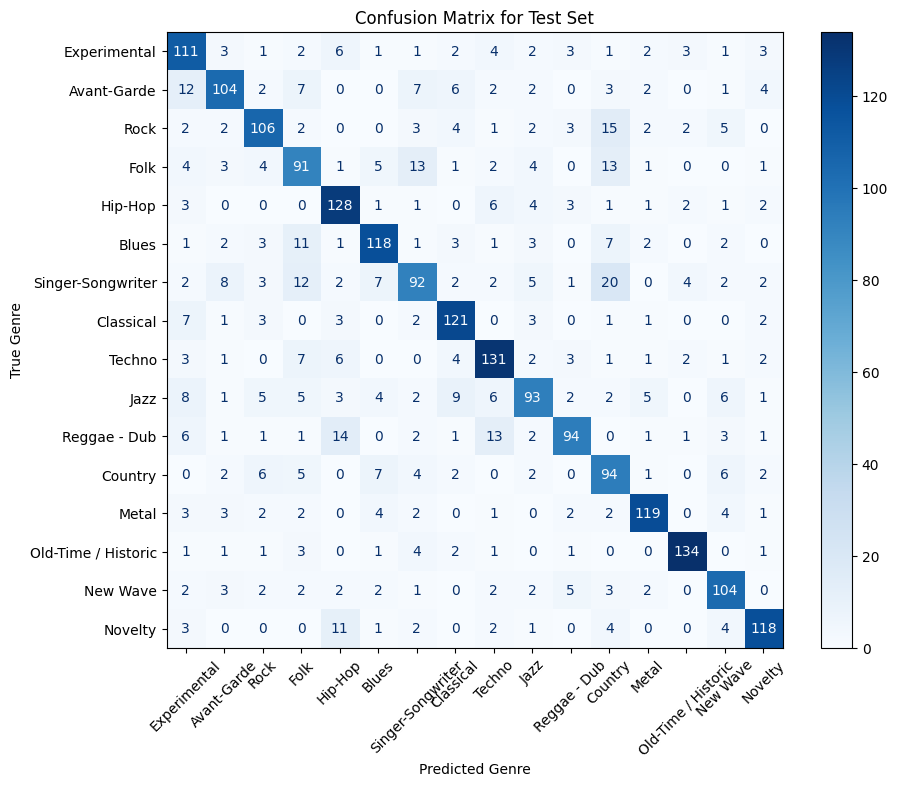


Test Set Accuracy: 74.27%


In [3]:
# Predict a sample from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]
predict(model, X_to_predict, y_to_predict)

import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# Load genre labels (mapping) from JSON file
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)
    genre_labels = data["mapping"]

# ================================================
# Confusion Matrix Plotting
# ================================================

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=genre_labels)  # Use genre names from the mapping
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)

# Set titles and labels
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.show()

accuracy = accuracy_score(y_test, y_pred_labels)
print(f"\nTest Set Accuracy: {accuracy * 100:.2f}%")

In [2]:
import json
import os
import math
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation
from tensorflow.keras.layers import PReLU, Layer
from tqdm import tqdm
import tensorflow as tf

# Configurations based on the paper
class Config:
    MCLNN_LAYER_COUNT = 2  
    DENSE_LAYER_COUNT = 2
    TOTAL_LAYER_COUNT = MCLNN_LAYER_COUNT + DENSE_LAYER_COUNT
    HIDDEN_NODES_LIST = [220, 200]  # Increased number of units
    DENSE_NODES = [50, 16]  # Increased number of units
    MASK_BANDWIDTH = [40, 10]  # Adjusted to match MCLNN_LAYER_COUNT
    MASK_OVERLAP = [-10, 3]
    LAYERS_ORDER_LIST = [4, 4]
    LAYER_IS_MASKED = [True,True]
    DROPOUT = [0.01, 0.35, 0.35, 0.1]  # Decreased dropout rates
    #DROPOUT = [0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5] 
    WEIGHT_INITIALIZATION = ['he_normal', 'he_normal', 'glorot_uniform', 'glorot_uniform']
    LEARNING_RATE = 0.0001

# MaskedConditional Layer (from your provided code)
class MaskedConditional(Layer):
    def __init__(self, output_dim, init='glorot_uniform', order=5, bandwidth=1, overlap=0, layer_is_masked=True, **kwargs):
        super(MaskedConditional, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.init = keras.initializers.get(init)
        self.order = order
        self.bandwidth = bandwidth
        self.overlap = overlap
        self.layer_is_masked = layer_is_masked

    def build(self, input_shape):
        input_dim = input_shape[-1]
        kernel_size = self.order * 2 + 1
        self.kernel_size = kernel_size

        # Initialize weights and biases
        self.W = self.add_weight(
            shape=(kernel_size, input_dim, self.output_dim),
            initializer=self.init,
            trainable=True,
            name='weights'
        )
        self.b = self.add_weight(
            shape=(self.output_dim,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

        # Construct mask
        self.weightmask = self.construct_mask(
            input_dim, self.output_dim, self.bandwidth, self.overlap, self.layer_is_masked
        )
        self.weightmask = tf.expand_dims(self.weightmask, axis=0)
        self.weightmask = tf.tile(self.weightmask, [kernel_size, 1, 1])
        self.W.assign(self.W * self.weightmask)

        super(MaskedConditional, self).build(input_shape)

    def construct_mask(self, feature_count, hidden_count, bandwidth, overlap, layer_is_masked):
        bw = bandwidth
        ov = overlap
        l = feature_count
        e = hidden_count

        a = np.arange(1, bw + 1)
        g = np.arange(1, int(np.ceil((l * e) / (l + bw - ov))) + 1)

        if not layer_is_masked:
            binary_mask = np.ones([l, e])
        else:
            mask = np.zeros([l, e])
            flat_matrix = mask.flatten('F')

            for i in range(len(a)):
                for j in range(len(g)):
                    lx = a[i] + (g[j] - 1) * (l + bw - ov)
                    if lx <= l * e:
                        flat_matrix[lx - 1] = 1

            binary_mask = np.transpose(flat_matrix.reshape(e, l))

        return binary_mask.astype(np.float32)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        sequence_length = tf.shape(inputs)[1]
        feature_count = tf.shape(inputs)[2]

        padding = self.order
        padded_inputs = tf.pad(inputs, [[0, 0], [padding, padding], [0, 0]], mode='CONSTANT')

        outputs = tf.nn.conv1d(padded_inputs, self.W, stride=1, padding='VALID')
        outputs = outputs + self.b
        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim)

# Build MCLNN Model
def build_model(input_shape, num_classes=16):
    inputs = Input(shape=(input_shape[0], input_shape[1]), name='input_layer')
    x = inputs

    # Add MCLNN layers
    for layer_index in range(Config.MCLNN_LAYER_COUNT):
        x = Dropout(Config.DROPOUT[layer_index])(x)
        x = MaskedConditional(
            init=Config.WEIGHT_INITIALIZATION[layer_index],
            output_dim=Config.HIDDEN_NODES_LIST[layer_index],
            order=Config.LAYERS_ORDER_LIST[layer_index],
            bandwidth=Config.MASK_BANDWIDTH[layer_index],
            overlap=Config.MASK_OVERLAP[layer_index],
            layer_is_masked=Config.LAYER_IS_MASKED[layer_index]
        )(x)
        x = PReLU(shared_axes=[1])(x)
        # Removed BatchNormalization

    # Global pooling layer
    x = GlobalAveragePooling1D()(x)

    # Add Dense layers including output layer
    for i in range(Config.DENSE_LAYER_COUNT):
        x = Dropout(Config.DROPOUT[i + Config.MCLNN_LAYER_COUNT])(x)
        x = Dense(
            units=Config.DENSE_NODES[i],
            kernel_initializer=Config.WEIGHT_INITIALIZATION[i + Config.MCLNN_LAYER_COUNT]
        )(x)
        if i < Config.DENSE_LAYER_COUNT - 1:
            x = PReLU()(x)  # Apply PReLU activation to x
        else:
            x = Activation('softmax')(x)  # Apply softmax activation for the output layer

    outputs = x

    model = Model(inputs, outputs)
    optimiser = keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Assume prepare_datasets and predict functions are defined elsewhere
if __name__ == "__main__":
    # Prepare datasets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.15, 0.15)

    # Squeeze the last dimension if it's 1 (remove unnecessary channels dimension)
    X_train = X_train.squeeze(-1)
    X_validation = X_validation.squeeze(-1)
    X_test = X_test.squeeze(-1)

    print(f"Adjusted X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Adjusted X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")

    # Build and compile the model
    input_shape = (X_train.shape[1], X_train.shape[2])  # Adjusted shape for MCLNN
    model = build_model(input_shape)
    model.summary()

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_validation, y_validation),
        batch_size=64,
        epochs=1000
    )

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nTest accuracy: {test_acc}')

    # Predict a sample from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]
    predict(model, X_to_predict, y_to_predict)

Adjusted X_train shape: (34203, 71, 13), y_train shape: (34203,)
Adjusted X_validation shape: (2012, 71, 13), y_validation shape: (2012,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 71, 13)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 71, 13)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conditional                   │ (None, 71, 220)             │          25,960 │
│ (MaskedConditional)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu (PReLU)                      │ (None, 71, 220)             │             220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 71, 220)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conditional_1                 │ (None, 71, 200)             │         396,200 │
│ (MaskedConditional)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_1 (PReLU)                    │ (None, 71, 200)             │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 200)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_2 (PReLU)                    │ (None, 50)                  │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 16)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 433,496 (1.65 MB)

 Trainable params: 433,496 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
535/535 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.1112 - loss: 4.4264 - val_accuracy: 0.1923 - val_loss: 2.5057
Epoch 2/1000
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1761 - loss: 2.5403 - val_accuracy: 0.2147 - val_loss: 2.4165
Epoch 3/1000
535/535 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.1995 - loss: 2.4718 - val_accuracy: 0.2679 - val_loss: 2.3203
Epoch 4/1000
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.2191 - loss: 2.4137 - val_accuracy: 0.2937 - val_loss: 2.2613
Epoch 5/1000
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.2404 - loss: 2.3633 - val_accuracy: 0.3246 - val_loss: 2.1924
Epoch 6/1000
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.2476 - loss: 2.3257 - val_accuracy: 0.3171 - val_loss: 2.1552
Epoch 7/1000
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.2610 - loss: 2.2938 - val_accuracy: 0.3429 - val_loss: 2.1161
Epoch 8/1000
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.2761 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Target: 3, Predicted label: [3]
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


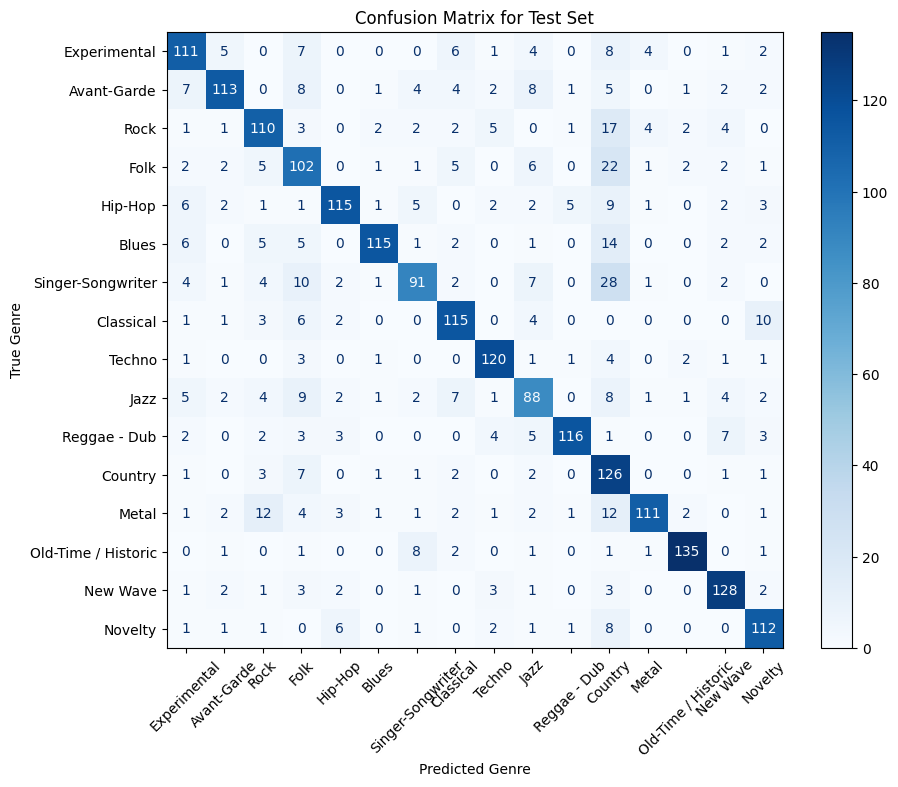


Test Set Accuracy: 76.38%


In [3]:
# Predict a sample from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]
predict(model, X_to_predict, y_to_predict)

import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# Load genre labels (mapping) from JSON file
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)
    genre_labels = data["mapping"]

# ================================================
# Confusion Matrix Plotting
# ================================================

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=genre_labels)  # Use genre names from the mapping
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)

# Set titles and labels
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.show()

accuracy = accuracy_score(y_test, y_pred_labels)
print(f"\nTest Set Accuracy: {accuracy * 100:.2f}%")

In [3]:
import json
import os
import math
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tqdm import tqdm
import json
import os
import math
import librosa

In [2]:
import pandas as pd

# Track counts per genre
genre_counts = {
'Experimental'           :7203,
'Avant-Garde'            :2931,
'Rock'                   :2229,
'Folk'                   :2177,
'Hip-Hop'                :2025,
'Blues'                   :662,
'Singer-Songwriter'       :654,
'Classical'               :563,
'Techno'                  :560,
'Jazz'                    :511,
'Reggae - Dub'            :297,
'Country'                 :293,
'Metal'                   :285,
'Old-Time / Historic'     :187,
'New Wave'                :176,
'Novelty'                  :87,
}

# Target number of tracks per genre
target_tracks = 100


# Calculate multiplier for each genre
multipliers = {genre: target_tracks / count for genre, count in genre_counts.items()}

# Display the result
multipliers_df = pd.DataFrame(list(multipliers.items()), columns=["Genre", "Multiplier"])
print(multipliers_df)


                  Genre  Multiplier
0          Experimental    0.013883
1           Avant-Garde    0.034118
2                  Rock    0.044863
3                  Folk    0.045935
4               Hip-Hop    0.049383
5                 Blues    0.151057
6     Singer-Songwriter    0.152905
7             Classical    0.177620
8                Techno    0.178571
9                  Jazz    0.195695
10         Reggae - Dub    0.336700
11              Country    0.341297
12                Metal    0.350877
13  Old-Time / Historic    0.534759
14             New Wave    0.568182
15              Novelty    1.149425


NameError: name 'le' is not defined